In [1]:

import nltk; nltk.download('stopwords')
!python3 -m spacy download en_core_web_sm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2023-08-26 12:07:02.210165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 12:07:03.712983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# !pip install pyLDAvis==2.1.2

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.model_selection import ParameterGrid


# spacy for lemmatization
import spacy

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

prepare stopwords

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edu', 'hi', 'Hi' 'thank', 's', 'thanks', 'please', 'ok'])

import json file data

In [5]:
df = pd.read_json('/content/chat_data.json')
df.head()

,1015096786,1015274995,1015275252,1015275450,1015275456,1015275479,1015275235,1015275488,1015298501,1015322814,...,1840060617,1840513982,1840464847,1841349819,1841350088,1841350642,1839841735,1841424091,1841431282,1841433317
status,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,...,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,OPEN,OPEN,OPEN
inboxId,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,...,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980
messages,"[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...",...,"[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'..."


Transpose dataframe to long

In [6]:
df_long = df.transpose()
df_long

,status,inboxId,messages
1015096786,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015274995,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275252,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275450,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275456,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
...,...,...,...
1841350642,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1839841735,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841424091,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841431282,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."


In [7]:
df_long.info

<bound method DataFrame.info of             status   inboxId  \
1015096786  CLOSED  70348980   
1015274995  CLOSED  70348980   
1015275252  CLOSED  70348980   
1015275450  CLOSED  70348980   
1015275456  CLOSED  70348980   
...            ...       ...   
1841350642  CLOSED  70348980   
1839841735  CLOSED  70348980   
1841424091    OPEN  70348980   
1841431282    OPEN  70348980   
1841433317    OPEN  70348980   

                                                     messages  
1015096786  [{'text': None, 'updatedAt': None, 'direction'...  
1015274995  [{'text': None, 'updatedAt': None, 'direction'...  
1015275252  [{'text': None, 'updatedAt': None, 'direction'...  
1015275450  [{'text': None, 'updatedAt': None, 'direction'...  
1015275456  [{'text': None, 'updatedAt': None, 'direction'...  
...                                                       ...  
1841350642  [{'text': None, 'updatedAt': None, 'direction'...  
1839841735  [{'text': None, 'updatedAt': None, 'direction'...  
1841424

Set index as the id of the conversations

In [8]:
df_long.set_index(df_long.columns[0])
df_long.index.name = 'index'
df_long

,status,inboxId,messages
index,,,
1015096786,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015274995,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275252,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275450,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275456,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
...,...,...,...
1841350642,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1839841735,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841424091,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."


Cleaning up conversation and create histogram of most common message

In [9]:
from collections import defaultdict
import time
conversations = df_long.messages.tolist()

# clean up conversation
def valid(messages):
  if len(messages) <= 3:
    return False;
  # find first not null message
  firstRealMessage = next(filter(lambda message: message["text"] is not None, messages), None)
  # if the message contains 'not been active', remove it
  if "not been active" in firstRealMessage["text"]:
    return False;
  return True;


sanitized_conversations = list(filter(valid, conversations));
print(len(sanitized_conversations))

# creating a dictionary returning 0 instead of error if empty
# use as a count method
histo = defaultdict(int)
# sort histogram count for message frequency
for conversation in sanitized_conversations:
  for message in conversation:
    if message["text"] is not None:
      histo[message["text"]] += 1
sorted_histo = sorted(histo.items(), key=lambda x:x[1], reverse=True)

for i in range(1000):
  print(sorted_histo[i])



4477
('Please note, residential lending is currently via exclusive limited distribution only.', 3440)
('So we can put you in touch with the right team, tell us a bit about yourself...', 3313)
('You’re on your way to a better experience, more certainty and more control 💥', 3306)
("I'm an <CASE_IDENTIFIER> broker!", 3226)
('<EMAIL_ADDRESS>', 2325)
('Awesome! What can we help you with today?', 2307)
('<NAME> <NAME>', 1543)
('Something <NAME>', 1386)
("<NAME> <NAME>, thanks for reaching out to <CASE_IDENTIFIER> Broker Support! I'm <NAME> and I'll be assisting you. Let me take a moment to read what you've shared.", 1337)
('Amazing stuff Superhero! What’s your name?', 1322)
("Cool, thanks <NAME>. What's your email address registered with <CASE_IDENTIFIER>?", 1280)
('Do you have a criteria question?', 1122)
("I'm going to close this chat. Our marketing team might reach out to get your feedback, I'd <NAME> to hear it! This feedback allows me to grow as a support specialist and continue to prov

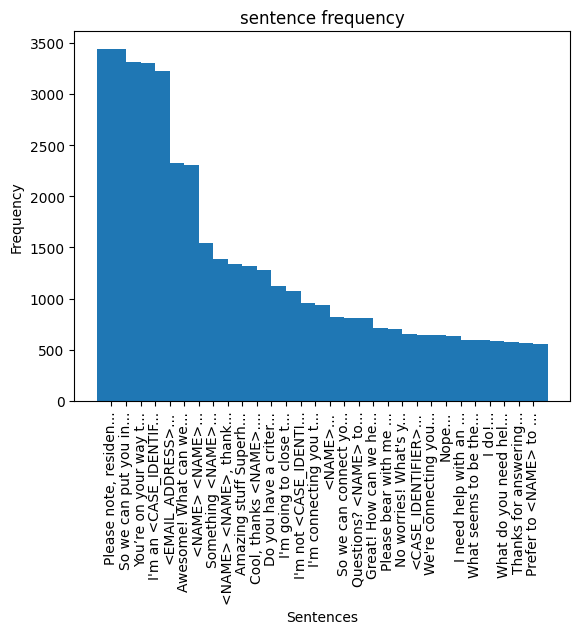

In [10]:
sortedplot = sorted_histo[:30]

plt.bar([entry[0][:20]+'...' for entry in sortedplot], [entry[1] for entry in sortedplot], width=2)
plt.xlabel('Sentences')
plt.ylabel('Frequency')
plt.title('sentence frequency')
plt.xticks(rotation=90)

plt.show()

In [54]:
# after cleaning
histo = defaultdict(int)
# sort histogram count for message frequency
for conversation in sanitized_conversations_filtered:
  for message in conversation:
    if message["text"] is not None:
      histo[message["text"]] += 1
sorted_histo = sorted(histo.items(), key=lambda x:x[1], reverse=True)

for i in range(1000):
  print(sorted_histo[i])

('', 544)
('Hi ', 410)
('Thank you', 283)
('How can I help you today?', 271)
(' ', 214)
('thank you', 202)
('Have a great .', 155)
('thanks', 150)
('How can i help?', 124)
('ok', 121)
('Hello ', 111)
('You re welcome. Have a great .', 109)
('How can we help you today', 109)
('yes', 102)
('Thanks', 101)
('?', 93)
('ok thanks', 93)
('You re welcome.', 90)
('thank you ', 84)
('Thank you.', 84)
('Hello', 70)
('ok thank you', 69)
('Have a great ', 66)
('Thank you ', 65)
('How can we help you today?', 65)
('Hi', 65)
('Yes', 63)
('Hello?', 60)
('Hi ! Thank you for contacting . How I assist you today?', 54)
('Thanks ', 48)
('£', 47)
('hi', 45)
('no thanks', 44)
('hello?', 42)
('Have a ', 42)
('thanks ', 41)
(' & ', 40)
('No problem', 39)
('hi ', 38)
('ok thanks ', 37)
('hello', 37)
('How can I help you ?', 37)
('no thank you', 35)
('how can i help?', 33)
('That s correct.', 32)
('How can I help?', 31)
('You re welcome. ', 31)
('have a ', 30)
('It looks like you ve not been active for a while .

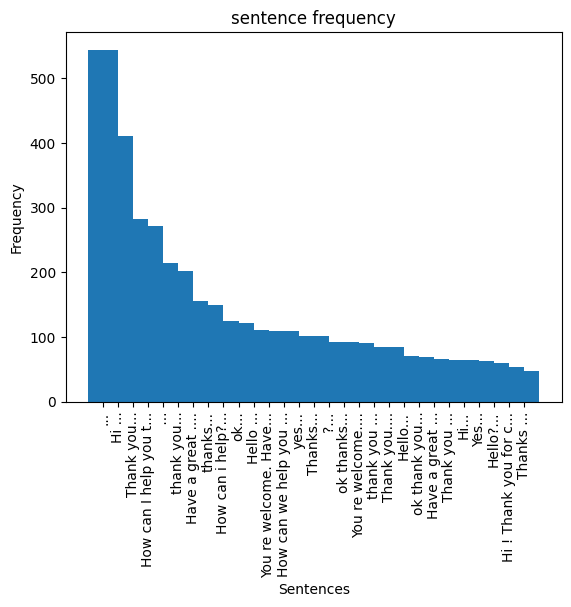

In [55]:
sortedplot = sorted_histo[:30]

plt.bar([entry[0][:20]+'...' for entry in sortedplot], [entry[1] for entry in sortedplot], width=2)
plt.xlabel('Sentences')
plt.ylabel('Frequency')
plt.title('sentence frequency')
plt.xticks(rotation=90)

plt.show()

In [11]:
# remove conversations that are None by filtering out the null messages
print(sanitized_conversations[0])
for i, conversation in enumerate(sanitized_conversations):
    sanitized_conversations[i] = list(filter(lambda message: message["text"] is not None, conversation))
print(sanitized_conversations[:2])

[{'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': "First Name: <NAME>\nLast Name: <NAME>\nEmail: <EMAIL_ADDRESS>\nWhy I&#x27;m submitting a request...: Something's broken\nAre you raising this ticket on behalf of a broker?: No\nCategory: Platform (kanban)\nPlatform subcategories: Access issues\nIssue: Used to be able to access the LIVE platform - no longer have access\n<NAME> issue: No\n", 'updatedAt': '2022-02-14T10:09:31.672Z', 'direction': 'INCOMING'}]
[[{'text': "First Name: <NAME>\nLast Name: <NAME>\nEmail: <EMAIL_ADDRESS>\nWhy I&#x27;m submitting a request...: Something's broken\nAre you raising this ticket on behalf of a broker?: No\nCategory: Platform (kanban)\nPlatform subcategories: Access issues\nIssue: Used to be able to access the LIVE platform - no longer have access\n<NAME> issue: No\n", 'updatedAt

In [12]:
# delete non-live conversation that doesn't connect to a customer support
def counter(messages):
  for message in messages:
    if "a member of our Broker Support team now" in message['text']:
      return True
  return False

sanitized_conversations = list(filter(counter, sanitized_conversations));
print(len(sanitized_conversations))

2656


In [13]:
pprint(sanitized_conversations[:6])

[[{'direction': 'OUTGOING',
   'text': 'Ok.  Enjoy your <NAME> and thank you for contacting '
           '<CASE_IDENTIFIER>!',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'OUTGOING',
   'text': "You're welcome!  Is there anything <NAME> I can help you with?",
   'updatedAt': '2022-05-18T09:19:19.416Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you\xa0',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal.  '
           'Before you click through to view <NAME> you will see a drop down '
           'arrow that will show a <NAME> of documents.  One of those '
           "documents will be called 'Broker's Audit'.  This will be detail of "
           'everything

In [14]:
# find message where connect to support team and delete everything before
# or other messages that is autogen
for conv in sanitized_conversations:
  for i, message in enumerate(conv):
    if "a member of our Broker Support team" in message["text"]:
      del conv[i:len(conv)]

sanitized_conversations_filtered = []
for conv in sanitized_conversations:
  filtered_conv = []
  for i, message in enumerate(conv):
    if "residential lending is currently via exclusive limited" in message["text"]:
      continue;
    if "take a moment to read what you've shared" in message["text"]:
      continue;
    if "going to close this chat" in message["text"]:
      continue;
    if "busier than usual" in message["text"]:
      continue;
    if "and I'll be assisting you" in message["text"]:
      continue;
    if "bear with me" in message["text"]:
      continue;
    if "Is there anything" in message["text"]:
      continue;
    if "is there anything" in message["text"]:
      continue;
    if "security questions" in message["text"]:
      continue;
    if "can I assist" in message["text"]:
      continue;
    filtered_conv.append(message)
  sanitized_conversations_filtered.append(filtered_conv)

In [15]:
print(len(sanitized_conversations_filtered))

2656


In [16]:
pprint(sanitized_conversations_filtered[:6])

[[{'direction': 'OUTGOING',
   'text': 'Ok.  Enjoy your <NAME> and thank you for contacting '
           '<CASE_IDENTIFIER>!',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you\xa0',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal.  '
           'Before you click through to view <NAME> you will see a drop down '
           'arrow that will show a <NAME> of documents.  One of those '
           "documents will be called 'Broker's Audit'.  This will be detail of "
           'everything that has been keyed to the application.',
   'updatedAt': '2022-05-18T09:17:43.335Z'},
  {'direction': 'INCOMING',
   'text': 'submitted one',
   'up

In [17]:
# remove angle bracket content, remove newline characters, remove single and double quotes
for conversation in sanitized_conversations_filtered:
  for message in conversation:
    message['text'] = re.sub('[\<(\[].*?[\>)\]]', '', message['text'])
    message['text'] = re.sub('\s+', ' ', message['text'])
    message['text'] = re.sub('\'', ' ', message['text'])

pprint(sanitized_conversations_filtered[:5])

[[{'direction': 'OUTGOING',
   'text': 'Ok. Enjoy your and thank you for contacting !',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you ',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal. '
           'Before you click through to view you will see a drop down arrow '
           'that will show a of documents. One of those documents will be '
           'called  Broker s Audit . This will be detail of everything that '
           'has been keyed to the application.',
   'updatedAt': '2022-05-18T09:17:43.335Z'},
  {'direction': 'INCOMING',
   'text': 'submitted one',
   'updatedAt': '2022-05-18T09:15:45.810Z'},
  {'direction': 'INC

In [18]:
# add messages to new list
words = []
for conv in sanitized_conversations_filtered:
  for message in conv:
      words.append(message['text'])

print(words[:2])
print(len(words))
print(len(words[1]))

print(words[3800:3801])
print(type(words)) # previous 36602

['Ok. Enjoy your and thank you for contacting !', 'no thank you :)']
30122
15
['Underwriting has up to review ']
<class 'list'>


In [19]:
# remove stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
# Remove Stop Words
clean_words_nostops = remove_stopwords(words)

# tokenize(split sentences into words) words + clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

clean_words = list(sent_to_words(clean_words_nostops)) # uncomment when rerun

print(clean_words[3850])


['look']


In [20]:
print(clean_words[1])

['thank']


In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[clean_words[3850]]])

['look']


In [22]:
# option 1 with constraints
# make bigrams and trigrams, lemmatization - changing words to base form
# Define functions for stopwords, bigrams, trigrams and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Form Bigrams
clean_words_bigrams = make_bigrams(clean_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(clean_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])
print(data_lemmatized[3850])

[['enjoy', 'thank', 'contact'], ['thank']]
['look']


In [23]:
print(data_lemmatized[:5])

[['enjoy', 'thank', 'contact'], ['thank'], ['s', 'helpful'], ['get', 'thank'], ['download', 'application', 'log', 'portal', 'click', 'view', 'see', 'drop', 'arrow', 'show', 'document', 'document', 'call', 'broker', 'audit', 'detail', 'key', 'application']]


Giving each word an ID and how many times it appears

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 1), (1, 1), (2, 1)]]
[[('contact', 1), ('enjoy', 1), ('thank', 1)]]


In [51]:
# 1 base model

# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                  id2word=id2word,
                  num_topics=11,
                  update_every=1,
                  chunksize=7000,
                  passes=9,
                  alpha='auto',
                  per_word_topics=True,
                  random_state=1)


In [52]:
# 1

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.055*"income" + 0.047*"client" + 0.038*"property" + 0.032*"accept" + '
  '0.021*"use" + 0.020*"consider" + 0.019*"purchase" + 0.019*"employ" + '
  '0.017*"contract" + 0.017*"new"'),
 (1,
  '0.068*"see" + 0.039*"go" + 0.032*"application" + 0.032*"change" + '
  '0.029*"rate" + 0.028*"able" + 0.019*"find" + 0.019*"tell" + 0.017*"log" + '
  '0.017*"end"'),
 (2,
  '0.076*"email" + 0.057*"offer" + 0.056*"send" + 0.036*"solicitor" + '
  '0.034*"register" + 0.029*"link" + 0.028*"broker" + 0.025*"update" + '
  '0.025*"receive" + 0.024*"sign"'),
 (3,
  '0.045*"know" + 0.043*"question" + 0.024*"applicant" + 0.022*"need" + '
  '0.021*"let" + 0.020*"see" + 0.019*"call" + 0.018*"valuation" + '
  '0.018*"credit" + 0.018*"check"'),
 (4,
  '0.065*"get" + 0.047*"try" + 0.043*"work" + 0.033*"submit" + 0.033*"look" + '
  '0.020*"application" + 0.020*"issue" + 0.019*"say" + 0.018*"think" + '
  '0.016*"complete"'),
 (5,
  '0.115*"great" + 0.115*"confirm" + 0.077*"loan" + 0.077*"number" + '
  '0.057

In [53]:
# 1

# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.807240406242522
Coherence Score:  0.5292877041193197


In [39]:
def compute_coherence_values(dictionary, corpus, texts, param_grid, random_seed=None):
    coherence_values = []
    model_list = []

    for params in ParameterGrid(param_grid):
        num_topics = params['num_topics']
        chunksize = params['chunksize']
        passes = params['passes']

        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                         chunksize=chunksize, passes=passes, random_state=random_seed)


        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
        co_score = coherencemodel.get_coherence()

        model_config = {
            'num_topics': num_topics,
            'chunksize': chunksize,
            'passes': passes,
            'coherence_score': co_score
        }
        model_list.append(model_config)

        print(model_list)

    return model_list #, coherence_values

param_grid = {
    'num_topics': [x for x in range(5, 15, 1)],
    'passes': [x for x in range(1, 10, 2)],
    'chunksize': [x for x in range(1000, 10000, 2000)]
}

model_list = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, param_grid=param_grid, random_seed=1)


Output hidden; open in https://colab.research.google.com to view.

In [44]:
import json
def write_list_of_lists_to_file(data, filename):
    with open(filename, 'w') as file:
        for string in data:
          json.dump(string, file)
          file.write('\n')

# Write the list of lists to the file
write_list_of_lists_to_file(model_list, 'lda_score.txt')

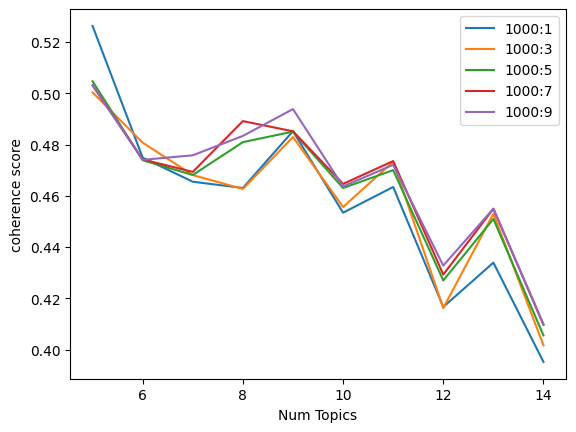

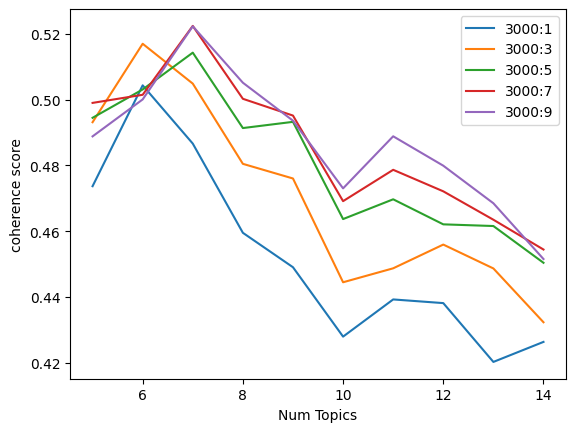

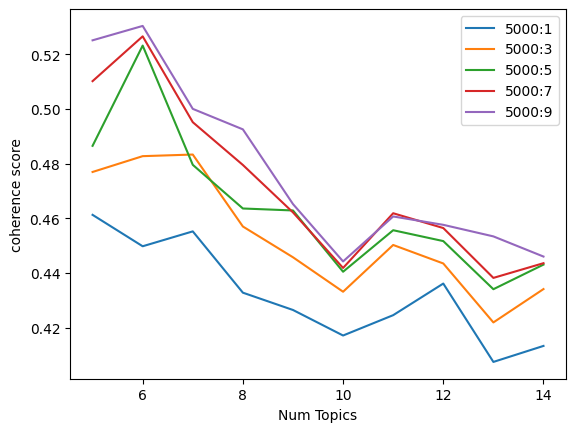

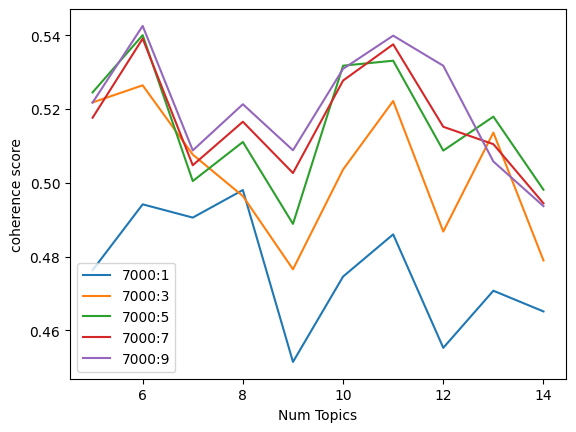

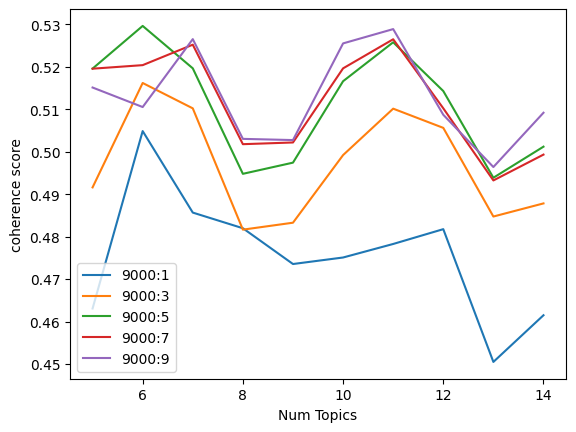

In [47]:
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==1 and score['chunksize']==1000], label='1000:1')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==3 and score['chunksize']==1000], label='1000:3')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==5 and score['chunksize']==1000], label='1000:5')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==7 and score['chunksize']==1000], label='1000:7')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==9 and score['chunksize']==1000], label='1000:9')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend()
plt.show()

plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==1 and score['chunksize']==3000], label='3000:1')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==3 and score['chunksize']==3000], label='3000:3')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==5 and score['chunksize']==3000], label='3000:5')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==7 and score['chunksize']==3000], label='3000:7')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==9 and score['chunksize']==3000], label='3000:9')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend()
plt.show()

plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==1 and score['chunksize']==5000], label='5000:1')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==3 and score['chunksize']==5000], label='5000:3')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==5 and score['chunksize']==5000], label='5000:5')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==7 and score['chunksize']==5000], label='5000:7')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==9 and score['chunksize']==5000], label='5000:9')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend()
plt.show()

plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==1 and score['chunksize']==7000], label='7000:1')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==3 and score['chunksize']==7000], label='7000:3')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==5 and score['chunksize']==7000], label='7000:5')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==7 and score['chunksize']==7000], label='7000:7')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==9 and score['chunksize']==7000], label='7000:9')
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend()
plt.show()

plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==1 and score['chunksize']==9000], label='9000:1')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==3 and score['chunksize']==9000], label='9000:3')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==5 and score['chunksize']==9000], label='9000:5')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==7 and score['chunksize']==9000], label='9000:7')
plt.plot(param_grid['num_topics'], [score['coherence_score'] for score in model_list if score['passes']==9 and score['chunksize']==9000], label='9000:9')

plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()